In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import itertools
import math
import scipy
import copy

# Hamiltonian

The Hamiltonian:
$$
H
=
\frac{1}{2m} \Big(\vec p - \frac{q}{c} \vec A \Big)^2
=
\frac{1}{2m} \Big( -i\hbar \vec\nabla - \frac{q}{c} \vec A \Big)^2
=
-
\frac{\hbar^2}{2m}
\Big( \vec\nabla - i \frac{q}{c\hbar} \vec A \Big)^2
=
-
\frac{\hbar^2}{2m} \vec\nabla^2
+
i
\frac{\hbar q}{2 m c}
(\vec\nabla \cdot \vec A)
+
i
\frac{\hbar q}{m c}
\vec A \cdot \vec\nabla
+
\frac{q^2}{2m c^2} A^2
$$
with:
$$
A = \frac{1}{2} B \begin{pmatrix} -y \\ +x \\ 0 \end{pmatrix}
$$
there is:
$$
H
=
-
\frac{\hbar^2}{2m} \vec\nabla^2
+
i
\frac{\hbar q B}{2 m c}
( -y \partial_x + x \partial_y)
+
\frac{q^2 B^2}{8mc^2} (x^2 + y^2)
$$

With cenvenient variables:
$$
\omega_L = \frac{q B}{mc}
$$
there is
$$
H
=
-
\frac{\hbar^2}{2m} \vec\nabla^2
+
i
\frac{\hbar \omega_L}{2}
( -y \partial_x + x \partial_y)
+
\frac{m\omega_L^2}{8} (x^2 + y^2)
$$

In [8]:
def simulate(data):
    data = copy.deepcopy(data)
    # Particle variables -- independent variables:
    m = data.setdefault("m", 1)
    q = data.setdefault("q", 1)
    B = data.setdefault("B", 1)
    # Geometry -- independent variables:
    px_size = data.setdefault("px_size", 0.005014) # 0.005014 relates to one flux quanta when n_x, n_y = 500, 500
    n_x = data.setdefault("n_x", 500)
    n_y = data.setdefault("n_y", 500)
    # Magnetic variables -- dependent variables:
    ω_L = q * B / m
    ω = ω_L / 2
    x_0 = math.sqrt((1 / 2) * 1 / (m * ω))
    p_0 = math.sqrt((1 / 2) * (m * ω))
    data["ω_L"] = ω_L
    data["ω"] = ω
    data["x_0"] = x_0
    data["p_0"] = p_0
    data["x_0/px_size"] = x_0 / px_size
    # Geometry -- dependent variables:
    x_stab = n_x * px_size
    y_stab = n_y * px_size
    data["x_stab"] = x_stab
    data["y_stab"] = y_stab
    # Flux:
    flux_0 = (2 * math.pi) / q
    flux = B * n_x * n_y * px_size**2
    data["flux_0"] = flux_0
    data["flux"] = flux
    data["flux/flux_0"] = flux/flux_0

    def hamiltonian_maxvec(v):
        v = v.reshape((n_x, n_y))
        # slice_x_one_0 = slice(0, n_x - 1)
        # slice_x_one_1 = slice(1, n_x)
        slice_x_0 = slice(0, n_x - 1)
        slice_x_1 = slice(1, n_x)
        slice_y_0 = slice(0, n_y - 1)
        slice_y_1 = slice(1, n_y)
        xs = np.arange(0, n_x * px_size, px_size) - n_x / 2 * px_size
        ys = np.arange(0, n_y * px_size, px_size) - n_y / 2 * px_size
        xs = xs.reshape((n_x, 1))
        ys = ys.reshape((1, n_y))
        # compute result
        result = np.zeros((n_x, n_y,), dtype=complex)
        # ((1 / 2) / m) (p_x^2 + p_y^2):
        result += (-(1 / 2) / m) * (-4 / px_size**2) * v
        result[slice_x_1, :] += (-(1 / 2) / m) * (+1 / px_size**2) * v[slice_x_0, :]
        result[slice_x_0, :] += (-(1 / 2) / m) * (+1 / px_size**2) * v[slice_x_1, :]
        result[:, slice_y_1] += (-(1 / 2) / m) * (+1 / px_size**2) * v[:, slice_y_0]
        result[:, slice_y_0] += (-(1 / 2) / m) * (+1 / px_size**2) * v[:, slice_y_1]
        # ((1 / 2) * m * ω**2) * (x**2 + y**2):
        result += ((1 / 2) * m * ω**2) * (xs**2 + ys**2) * v
        # (-ω) * (-y * p_x):
        result[slice_x_1, :] += (-ω) * (-1) * ys * (-1j) * (- 1 / (2 * px_size)) * v[slice_x_0, :]
        result[slice_x_0, :] += (-ω) * (-1) * ys * (-1j) * (+ 1 / (2 * px_size)) * v[slice_x_1, :]
        # (-ω) * (+x * p_y):
        result[:, slice_y_1] += (-ω) * (+1) * xs * (-1j) * (- 1 / (2 * px_size)) * v[:, slice_y_0]
        result[:, slice_y_0] += (-ω) * (+1) * xs * (-1j) * (+ 1 / (2 * px_size)) * v[:, slice_y_1]
        # finish:
        result = result.reshape((n_x * n_y,))
        return result
    
    n_bands_to_show = data.setdefault("n_bands_to_show", 4)
    higher_energy_to_show = (0.5 + n_bands_to_show) * data['ω_L']
    data["higher_energy_to_show"] = higher_energy_to_show
    number_of_eigvals = int(math.ceil(n_bands_to_show * flux / flux_0))
    # print(f"----> number_of_eigvals: {number_of_eigvals}")
    hamiltonian_linearoperator = scipy.sparse.linalg.LinearOperator((n_x * n_y, n_x * n_y), matvec=hamiltonian_maxvec)
    eigvals = scipy.sparse.linalg.eigsh(hamiltonian_linearoperator, k=number_of_eigvals, return_eigenvectors=False, which='SA')
    eigvals = eigvals[::-1]
    data["eigvals"] = eigvals
    data["number_of_eigvals"] = number_of_eigvals
    return data

In [9]:
def present_data(data):
    print("Particle variables:")
    print(f" • m={data['m']}")
    print(f" • q={data['q']}")
    print(f" • B={data['B']}")
    print(f" • ω_L={data['ω_L']}")
    print(f" • ω={data['ω']}")
    print(f" • x_0={data['x_0']}")
    print(f" • p_0={data['p_0']}")
    print("Goemtric variables:")
    print(f" • px_size={data['px_size']}")
    print(f" • x_0/px_size={data['x_0/px_size']}")
    print(f" • x_stab={data['x_stab']}")
    print(f" • y_stab={data['y_stab']}")
    print("Flux:")
    print(f" • flux_0={data['flux_0']}")
    print(f" • flux={data['flux']}")
    print(f" • flux/flux_0={data['flux/flux_0']}")
    fig, ax = plt.subplots()
    ax.scatter(range(data['number_of_eigvals']), data['eigvals'] / data['ω_L'])
    ax.plot(range(data['number_of_eigvals']), data['eigvals'] / data['ω_L'])
    ax.grid()
    ax.set_title(f"Landau levels (with $B={data['B']}$)")
    n_states_to_show = (data['eigvals'] <= data['higher_energy_to_show']).sum()
    ax.set_xticks(np.arange(0, n_states_to_show + 5, 5))
    ax.set_yticks(np.arange(0, data['higher_energy_to_show'] + 0.5, 0.5))
    ax.set_xlim((0, n_states_to_show))
    ax.set_ylim((0.0, data['higher_energy_to_show'] / data['ω_L']))
    ax.set_xlabel("eigenstate #")
    ax.set_ylabel("$E / \omega_L$")
    plt.show()

----> number_of_eigvals: 65
Particle variables:
 • m=1
 • q=1
 • B=16
 • ω_L=16.0
 • ω=8.0
 • x_0=0.25
 • p_0=2.0
Goemtric variables:
 • px_size=0.005014
 • x_0/px_size=49.8603909054647
 • x_stab=2.507
 • y_stab=2.507
Flux:
 • flux_0=6.283185307179586
 • flux=100.56078400000001
 • flux/flux_0=16.004745854796383


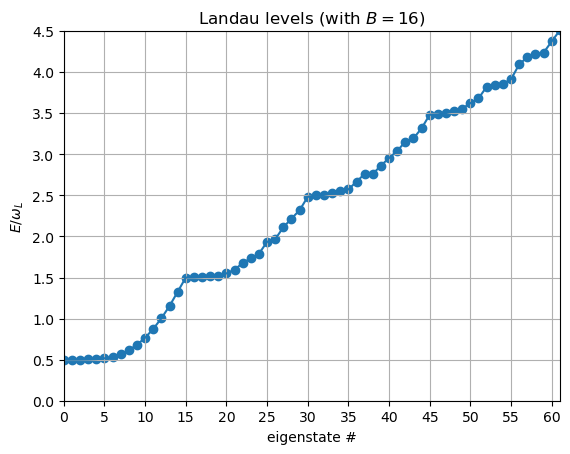

In [10]:
data_B16 = simulate({"B": 16})
present_data(data_B16)

----> number_of_eigvals: 101
Particle variables:
 • m=1
 • q=1
 • B=25
 • ω_L=25.0
 • ω=12.5
 • x_0=0.2
 • p_0=2.5
Goemtric variables:
 • px_size=0.005014
 • x_0/px_size=39.88831272437176
 • x_stab=2.507
 • y_stab=2.507
Flux:
 • flux_0=6.283185307179586
 • flux=157.126225
 • flux/flux_0=25.007415398119345


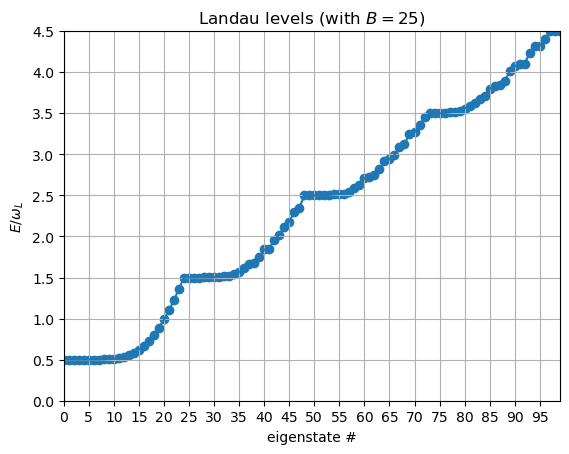

In [11]:
data_B25 = simulate({"B": 25})
present_data(data_B25)